In [1]:
import numpy as np 

In [2]:
from utils import generate_inputs_test as gen, adam, initialize_adam

In [3]:
def params_init(nx : int, seed : int = None):

    # generate the sample random numbers 
    if seed : np.random.seed(seed=seed)
    # initializing params as python dictionary 
    params = {}

    # creating weight and bias for one neuron
    # as we said to the README file we just have one neuron (binary classification)
    ny = 1
    for i in range(ny):
        params[f'W{i+1}'] = np.random.randn(1, nx) * 0.01
        params[f'b{i+1}'] = np.zeros((1, 1))

    # returning the output as a dictionary
    return params 

In [4]:
def sigmoid(x : int):
    # computing sigmoid function for a given value x 

    sig = 1. / (1 + np.exp(-x))

    return sig 

In [5]:
def forward_propagation(X : np.ndarray, params : dict):
    # layers 
    layers = len(list(params.keys())) // 2

    # linearity & prediction 
    # Z = W.dot(X) + b
    # A = sigmoid(Z)
    Z, A = {},{}
  
    for layer in range(layers):
        # linearity
        Z[layer+1] = params[f"W{layer+1}"].dot(X) + params[f'b{layer+1}']
        # prediction
        A[layer+1] = sigmoid(x=Z[layer+1])
    
    cache = {"Z" : Z, "A" : A}

    return A[layer+1], cache 

In [6]:
def cost_function(A : np.ndarray, Y: np.ndarray):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    * A -- The activation output of the last layer, of shape (sy, m)
    * Y -- "true" labels vector of shape (ny, m)

    in the case of binary classification ny = 1
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    A.shape = 
    Y.shape = (1, ny)
    """
    
    m       = Y.shape[1] 
    cost    = (1./m) * (-np.dot(Y, np.log(A).T) - np.dot(1-Y, np.log(1-A).T))
    # np.squeeze(cost) --> np.squeeze([[1]]) = 1.0
    cost    = float(np.squeeze(cost))   
                                    
    return cost

In [7]:
def backward_propagation(
        params  : dict, 
        cache   : dict, 
        X       : np.ndarray, 
        Y       : np.ndarray
        ):
    
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    params -- python dictionary containing our parameters 
    cache -- a dictionary containing A, and Z (activations and linear calculations).
    X -- input data of shape (nx, number of examples)
    Y -- "true" labels vector of shape (ny, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    # nomber of sample 
    m       = X.shape[1]
    # intialize gradient 
    grads   = {}
    # restoring activation & linearity from cache 
    A, Z    = cache['A'], cache['Z']  
    # computing the number of layers 
    layers  = len(list(params.keys())) // 2

    # updating gradient 
    # dZ = A[layers] - Y
    grads[f'dZ{layers}'] = A[layers] - Y
    # dW = dZ.dot(X.T)
    grads[f'dW{layers}'] = grads[f'dZ{layers}'].dot( X.T) / m
    # db = 1
    grads[f'db{layers}'] = np.sum(grads[f'dZ{layers}'], axis=1, keepdims=True) / m

    return grads 

In [8]:
def clip(gradients : dict = {}, maxValue : float = 10):

    """
    clip funsion is ued to solve the issue of exploding gradient.
    by fixing the border limits the gradient cannot exceded we can solve that problem 

    * firstly we start by defining the border limits [-L, L]
    if the value of gardient id outside of this range we put it inside like this 
        - if grad > L  ---> grad = L
        - if grad < -L ---> grad = L
        - else grad = pass

    * so to make it possible we need the value of L in this case L = maxValues argument

    """
    
    for key, value in gradients.items():
        np.clip(a=value, a_min=-maxValue, a_max=maxValue, out=value)

        gradients[key] = value

    return gradients


In [9]:
def prediction(A, as_bool : bool = True):
    
    prediction =  A > 0.5
    
    if as_bool is True : return prediction * 1
    else: return A

def scoring(y_true : np.ndarray, y_pred : np.ndarray):

    return (y_pred == y_true).sum() / y_pred.shape[1]

In [10]:
def updating_params(grads : dict, params : dict, learning_rate : float = 0.01):

    # number of layers
    layers = len( list(params.keys()) ) // 2

    # updating the weight and bias using the gradient (stochastic gradient descend)
    for layer in range(layers):
        params[f'W{layer+1}'] = params[f'W{layer+1}'] - learning_rate * grads[f'dW{layer+1}']
        params[f'b{layer+1}'] = params[f'b{layer+1}'] - learning_rate * grads[f'db{layer+1}']

    # returning the updating weight and bias 

    return params

In [14]:
def LogisticRegression(
        X : np.ndarray,
        Y : np.ndarray,
        maxValue : float = None,
        early_stoping       : int   = 10000,
        learning_rate       : float = 1e-3,
        print_val           : bool  = True,
        epsilon             : float = 1e-8,
        verbose             : bool  = True,
        step                : int   = 100, 
        seed                : int   = None,
        optimizer           : str   = "sgd",
        beta1               : float = 0.8,
        beta2               : float = 0.85,
        t                   : float = 2.5
       ):

    nx      = X.shape[0]
    params  = params_init(nx=nx, seed=seed)

    history = {"cost" : [], "accuracy" : []}
    
    i = 0

    while True:
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache"
        A_last, cache = forward_propagation(X=X, params=params)
        
        # Cost function. Inputs: "A2, Y". Outputs: "cost".
        # cost = ...
        cost = cost_function(A=A_last, Y=Y)
        
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(params=params, cache=cache, X=X, Y=Y)
        
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        if maxValue : grads = clip(gradients=grads, maxValue=maxValue)

        if optimizer == "sgd" : params = updating_params(params=params, grads=grads, learning_rate=learning_rate)
        else:
            v, s = initialize_adam(params=params) 
            params,v, s = adam(params=params, grads=grads, v=v, s=s, t=t, beta1=beta1, beta2=beta2, learning_rate=learning_rate, epsilon=epsilon)
           
        y_pred      = prediction(A_last, as_bool=True)
        accuracy    = scoring(y_true=Y, y_pred=y_pred)
                        
        # Print the cost every 1000 iterations
        if verbose and i % step == 0:        
            if i == 0 : pass 
            else:
                if history['cost']:
                    if np.abs(history['cost'][-1] - cost) < epsilon: 
                        print("loop break due np.abs( cost[i] - cost[i-1]) < epsilon")
                        break
                    else: pass
                else: pass 

                history['cost'].append(cost)
                history['accuracy'].append(accuracy)

                if print_val : print ("epoch: %i cost: %f scoring: %f" %(i, cost, accuracy))
        else: pass 
        
        i += 1 

             
        if early_stoping:
            if i >= early_stoping: 
                print("loop break due to early stoping parameter")
                break 
            else: pass 
        else: pass
        
    return history 

In [15]:
nx = 8
X, y = gen(nx=nx, samples=10000)

In [21]:
history = LogisticRegression(X=X, Y=y, maxValue=None, print_val=True, learning_rate=0.1, beta1=0.9, beta2=0.99,
                                                step=100, early_stoping=10000, epsilon=1e-17, optimizer='adam')

epoch: 100 cost: 0.616652 scoring: 0.693300
epoch: 200 cost: 0.616652 scoring: 0.693300
epoch: 300 cost: 0.616652 scoring: 0.693300
epoch: 400 cost: 0.616652 scoring: 0.693300
epoch: 500 cost: 0.616652 scoring: 0.693300
epoch: 600 cost: 0.616652 scoring: 0.693300
epoch: 700 cost: 0.616652 scoring: 0.693300
epoch: 800 cost: 0.616652 scoring: 0.693300
epoch: 900 cost: 0.616652 scoring: 0.693300
epoch: 1000 cost: 0.616652 scoring: 0.693300
epoch: 1100 cost: 0.616652 scoring: 0.693300
epoch: 1200 cost: 0.616652 scoring: 0.693300
epoch: 1300 cost: 0.616652 scoring: 0.693300
epoch: 1400 cost: 0.616652 scoring: 0.693300
epoch: 1500 cost: 0.616652 scoring: 0.693300
epoch: 1600 cost: 0.616652 scoring: 0.693300
epoch: 1700 cost: 0.616652 scoring: 0.693300
epoch: 1800 cost: 0.616652 scoring: 0.693300
epoch: 1900 cost: 0.616652 scoring: 0.693300
epoch: 2000 cost: 0.616652 scoring: 0.693300
epoch: 2100 cost: 0.616652 scoring: 0.693300
epoch: 2200 cost: 0.616652 scoring: 0.693300
epoch: 2300 cost: 0

In [22]:
path  = 'https://sololearn.com/uploads/files/titanic.csv' 

In [23]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.feature_selection import RFE, VarianceThreshold, SelectPercentile
import pandas as pd

In [24]:
min_max = MinMaxScaler()
data = pd.read_csv(path, header=0)

In [25]:
data.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses,Parents/Children,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          887 non-null    int64  
 1   Pclass            887 non-null    int64  
 2   Sex               887 non-null    object 
 3   Age               887 non-null    float64
 4   Siblings/Spouses  887 non-null    int64  
 5   Parents/Children  887 non-null    int64  
 6   Fare              887 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.6+ KB


In [27]:
# checking duplicated values
duplicated_val = data.duplicated().sum()
print(f"before {duplicated_val}")

# removing duplicated values, i used here inplace to change dataframe directly
data.drop_duplicates(inplace=True)
print(f"after {data.duplicated().sum()}")

before 70
after 0


In [28]:
# checking null values 
null_vals = data.isna().sum()
print(f"not null values in this dataset\n{null_vals}")

not null values in this dataset
Survived            0
Pclass              0
Sex                 0
Age                 0
Siblings/Spouses    0
Parents/Children    0
Fare                0
dtype: int64


In [29]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV as Gs

In [30]:
encoder = LabelEncoder()
data['Sex'] = encoder.fit_transform(data['Sex'])
data.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses,Parents/Children,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [31]:
corr = data.corr()
corr

,Survived,Pclass,Sex,Age,Siblings/Spouses,Parents/Children,Fare
Survived,1.000000,-0.332440,-0.519580,-0.068815,-0.061802,0.063134,0.243279
Pclass,-0.332440,1.000000,0.112604,-0.387949,0.105392,0.038934,-0.548349
Sex,-0.519580,0.112604,1.000000,0.099127,-0.095775,-0.235186,-0.170175
Age,-0.068815,-0.387949,0.099127,1.000000,-0.308451,-0.203584,0.107156
Siblings/Spouses,-0.061802,0.105392,-0.095775,-0.308451,1.000000,0.403822,0.146354
Parents/Children,0.063134,0.038934,-0.235186,-0.203584,0.403822,1.000000,0.203017
Fare,0.243279,-0.548349,-0.170175,0.107156,0.146354,0.203017,1.000000


In [32]:
target = data['Survived']
X = data.drop(labels=['Survived'], axis=1)


C:\Users\amib\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amib\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amib\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


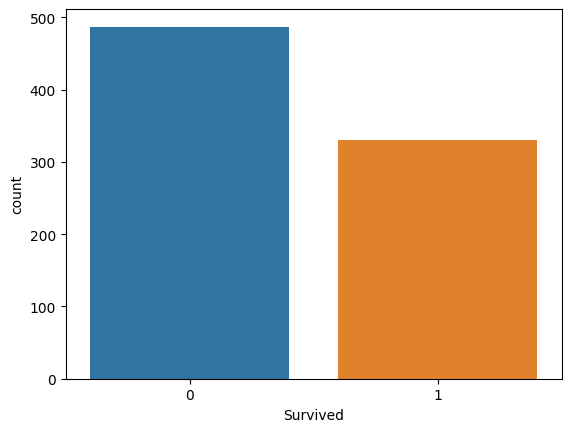

In [33]:

sns.countplot(x=target)
plt.show()

In [34]:
X_train, X_test, y_train, y_test = tts(X, target, test_size=0.2, random_state=3, stratify=target)

In [35]:
X_train = min_max.fit_transform(X_train)
X_test  = min_max.transform(X_test)

In [36]:
lr = LR()

In [37]:
rfe = RFE(estimator=lr)
X_train_rfe = rfe.fit_transform(X_train, y=y_train)
X_test_rfe  = rfe.transform(X_test)

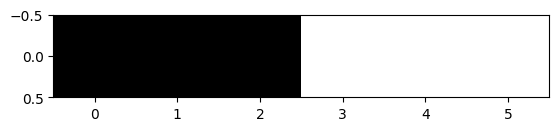

In [38]:
mask = rfe.get_support()
plt.imshow(mask.reshape((1, -1)), cmap="gray_r")
plt.show()

In [39]:
names = X.columns[mask]
names

Index(['Pclass', 'Sex', 'Age'], dtype='object')

In [40]:
param_grid = {
    "solver" : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    "C" : [0.01, 0.1, 1, 2, 5, 10]
}
gs = Gs(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')
gs.fit(X_train_rfe, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 2, 5, 10],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy')

In [41]:
gs.best_estimator_

LogisticRegression(C=2, solver='liblinear')

In [42]:
lr = LR(C=2, solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"score test : {lr.score(X_test, y_test)}")

score test : 0.8109756097560976


In [51]:
XX = X_train_rfe.reshape((3, -1))
YY = y_train.values.reshape((1, -1))

history = LogisticRegression(X=XX, Y=YY, maxValue=2, print_val=True, learning_rate=0.00005, beta1=0.9, beta2=0.99,
                                                step=1000, early_stoping=100000, epsilon=1e-17, optimizer='sgd')

epoch: 1000 cost: 0.685739 scoring: 0.595712
epoch: 2000 cost: 0.681472 scoring: 0.595712
epoch: 3000 cost: 0.678834 scoring: 0.595712
epoch: 4000 cost: 0.677193 scoring: 0.595712
epoch: 5000 cost: 0.676164 scoring: 0.595712
epoch: 6000 cost: 0.675512 scoring: 0.595712
epoch: 7000 cost: 0.675093 scoring: 0.595712
epoch: 8000 cost: 0.674819 scoring: 0.595712
epoch: 9000 cost: 0.674635 scoring: 0.595712
epoch: 10000 cost: 0.674507 scoring: 0.595712
epoch: 11000 cost: 0.674415 scoring: 0.595712
epoch: 12000 cost: 0.674345 scoring: 0.595712
epoch: 13000 cost: 0.674291 scoring: 0.595712
epoch: 14000 cost: 0.674245 scoring: 0.595712
epoch: 15000 cost: 0.674206 scoring: 0.595712
epoch: 16000 cost: 0.674172 scoring: 0.595712
epoch: 17000 cost: 0.674141 scoring: 0.595712
epoch: 18000 cost: 0.674112 scoring: 0.595712
epoch: 19000 cost: 0.674084 scoring: 0.595712
epoch: 20000 cost: 0.674059 scoring: 0.595712
epoch: 21000 cost: 0.674035 scoring: 0.595712
epoch: 22000 cost: 0.674012 scoring: 0.5957